# CMSC426, HW03, Shiyuan Duan, Code

## Introduction

In this project, we are implementing a color segmentation method by clustering color points in a RGB color space. The idea is that we fit a gaussian model or a GMM to the desired color, orange in this case, that is represented as a 3D point on a RGB color space. Then we use the trained GMM on the test-image to find the pixels that fits the GMM the most. Finally we will be looking for the distance from the object to the camera. There are several ways of doing it, in our case we will be using the object's area.

## Obtaining Training data

We are obtaining our training dataset by croping the pixels that represent the orange ball and collect them into a csv file(ball.csv). This can be done by executing crop.py

In [1]:
%matplotlib inline
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

In [2]:
X = np.genfromtxt('ball.csv', delimiter=',')
r = X[:,0]
g = X[:,1]
b = X[:,2]

We can visualize our data by ploting them on a 3D RGB color space

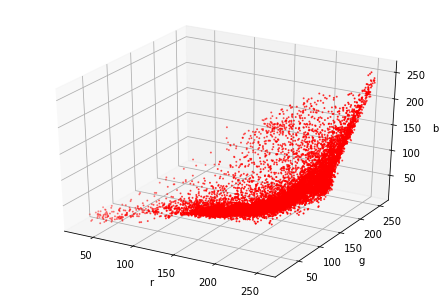

In [3]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(r,g,b,c='r',s=1)
ax.set_xlabel('r')
ax.set_ylabel('g')
ax.set_zlabel('b')
plt.show()

## Single Gaussian Model

When it comes to problems like clusering data points, it is usually done by gaussian models. The simplest model is a single gaussian model on a 3D color space. Let's implement it and see if it is expressive enough to describe our orange ball.

To get the single gaussian model, all we need is the covariance matrix and $\mu$ for our dataset.

In [4]:
mu = np.array([np.mean(r),np.mean(g),np.mean(b)])
cov = np.cov(X.T)

Now we can draw our gaussian model and visualize it. To do this we will be using a helper funciton.

In [5]:
def confidence_ellipsoid3(mu, cov, ax, conf=0.90, **kwargs):
    """ Plot a 3D ellipsoid using mu and covariance matrix
    
    Args:
    - mu: mean vector of the dataset (1x3)
    - cov: covariance matrix of the dataset (3x3)
    - ax: 3D axis. You can obtain one using `fig.gca(projection='3d')`
    - kwargs: customized styling of the ellipsoid
    Author:
    - Yu Fang
    """
    D, P = np.linalg.eig(cov)
    # automatic scaling using the confidence level
    scale = np.sqrt(chi2.ppf(conf, 3))

    # mesh using uv-coord
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    # transform to x,y,z, scaled by sqrt(lambda) in each axis
    x = np.sqrt(D[0]) * np.outer(np.cos(u), np.sin(v))
    y = np.sqrt(D[1]) * np.outer(np.sin(u), np.sin(v))
    z = np.sqrt(D[2]) * np.outer(np.ones_like(u), np.cos(v))
    # apply rotation, confidence scaling, translation
    xyz_trans = scale * (P @ np.vstack([x.flatten(),y.flatten(),z.flatten()])) + mu.reshape(3,1)
    x = xyz_trans[0].reshape(100,100)
    y = xyz_trans[1].reshape(100,100)
    z = xyz_trans[2].reshape(100,100)

    ax.plot_wireframe(x, y, z, linewidth=0.5, alpha=0.5, **kwargs)

### Plotting

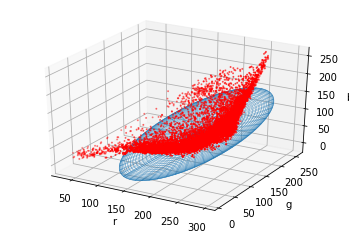

In [6]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(r,g,b,c='r',s=1)
ax.set_xlabel('r')
ax.set_ylabel('g')
ax.set_zlabel('b')
confidence_ellipsoid3(mu,cov,ax)

We can see that even though gaussian model captures some of the datapoints, most of the pixels are still not clustered well. Therefore a single gaussian model may not be able to describe the color orange very well. We need to use a GMM to fit our dataset

## GMM

The following code is from HW02. The only difference is that our dataset is very likely to run into a singular matrix. We have to reinitialize all parameters when it happens. The explaination of each step is in comments

In [7]:
import random

while True:
    # Choose number of gaussian models
    k=7
    # Read dataset
    dataset = X
    R, G, B = X[:,0], X[:,1], X[:,2]
    n = len(dataset)
    
    # Initializing mu by randomly selecting k data points
    sample_dataset = list(dataset)
    mu = random.sample(sample_dataset,k)
    mu = np.array(mu)
    
    
    # Initializing sig by using the covariace matrix of the single gaussian model
    sig = np.zeros((k,3,3))
    sig = np.array([cov for i in range(k)])
    
    # Initializing pi with 1/k because each model is eqaully likly to be selected.
    pi = np.ones((k,1))/k

    #normal distributions
    pdf_m = np.zeros((k,n))
    
    try:
        for i in range(100):
            # mu
            rvs = [multivariate_normal(mu[i], sig[i]) for i in range(k)]
            pdf_m = np.array([rvs[i].pdf(dataset) for i in range(k)])

            gamma = pdf_m*pi
            gamma_row = [np.sum(gamma[:,i]) for i in range(n)]
            gamma = gamma / gamma_row

            mu_numerator = gamma@dataset
            mu_denominator = np.array([np.sum(gamma[i]) for i in range(k)])
            mu_denominator = np.reshape(mu_denominator,(k,1))
            #print(np.linalg.norm(mu-(mu_numerator/mu_denominator)))
            mu = mu_numerator/mu_denominator

            # sig
            new_datasets = np.zeros((k,len(dataset),3))
            for i in range(k):
                new_datasets[i] = (np.vstack((R-mu[i][0],G-mu[i][1],B-mu[i][2])).T) * np.reshape(gamma[i],(n,1))

            for j in range(k):
                sig[j] = np.dot(new_datasets[j].T, new_datasets[j])/mu_denominator[j]

            #print(sig)

            #pi
            pi = np.array([np.sum(gamma[i]) for i in range(k)])
            pi /= n
            pi = np.reshape(pi, (k,1))
        break
    except Exception as e:
        pass


Now we get all the parameters for our GMM, we can plot it and see if K = 7 is enough to fit our dataset

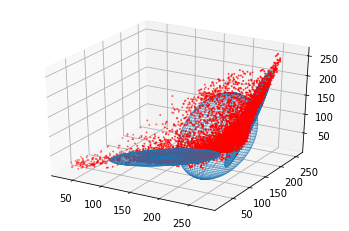

In [8]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(r,g,b,c='r',s=1)
for i in range(k):
    confidence_ellipsoid3(mu[i],sig[i],ax)

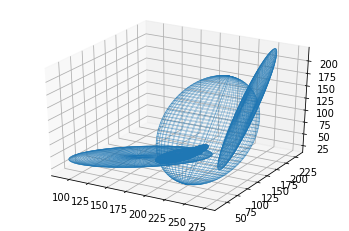

In [9]:
fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.scatter(r,g,b,c='r',s=1)
for i in range(k):
    confidence_ellipsoid3(mu[i],sig[i],ax)

We can see that a GMM with 7 gaussian models is able to capture most of the features.

Now what we want to do is that supress all the pixels that give us a low p-value, that is to supress all the pixels that are not orange. We can try it on a training image with a cutoff of 10^-7.

In [10]:
img = cv.imread('test_images/4.jpg')
b, g, r = cv.split(img)
print(np.shape(b))
b = b.flatten()
g = g.flatten()
r = r.flatten()
X = np.transpose(np.vstack((r,g,b)))

cut_off = 10e-7
pdf = [0]*len(X)
for j in range(k):
        pdf += multivariate_normal(mu[j],sig[j]).pdf(X)
        
for i in range(len(X)):
    if pdf[i] < cut_off:
        X[i] = np.array([0,0,0])
    else:
        X[i] = np.array([255,255,255])

(640, 480)


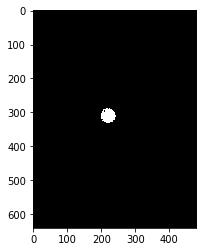

In [11]:
r = X[:,0]
r = np.reshape(r,(640,480))

g = X[:,1]
g = np.reshape(g,(640,480))

b = X[:,2]
b = np.reshape(b,(640,480))
plt.imshow(g,cmap = plt.cm.gray)
plt.show()

we can see that with our GMM we can successfully capture the ball. To get a better estimation of it's area we can reduce the noise by the following code 

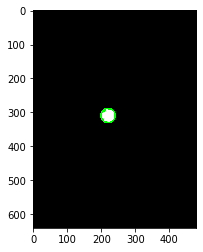

In [12]:
i = cv.merge((b,r,g))
kernel = np.ones((5,5),np.uint8)
i = cv.morphologyEx(i, cv.MORPH_OPEN, kernel)
i = cv.morphologyEx(i, cv.MORPH_CLOSE, kernel)

imgray = cv.cvtColor(i, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
(x,y),radius = cv.minEnclosingCircle(cnt)
center = (int(x),int(y))
radius = int(radius)
circle_img = cv.circle(i,center,radius,(0,255,0),2)
cnt_img = cv.drawContours(i, contours, -1, (0,255,0), 3)
plt.imshow(circle_img)
plt.show()

Now that we have obtained the contour we can calculate it's area. The area can be used to get an estimation of the distance

In [13]:
area = cv.contourArea(contours[0])
print(area)

1316.0


There is a relationship between area and distance. We can get all the area in the training set and discover this relation. To do this we need a helper function

In [14]:
def get_area(filename,root_file):
    img = cv.imread(root_file+ '/' + filename)
    img_shape = np.shape(img[:,:,0])
    b, g, r = cv.split(img)
    b = b.flatten()
    g = g.flatten()
    r = r.flatten()
    X = np.transpose(np.vstack((r,g,b)))
    
    cut_off = 10e-7
    pdf = [0]*len(X)
    for j in range(k):
            pdf += multivariate_normal(mu[j],sig[j]).pdf(X)

    for i in range(len(X)):
        if pdf[i] < cut_off:
            X[i] = np.array([0,0,0])
        else:
            X[i] = np.array([255,255,255])
            
    r = X[:,0]
    r = np.reshape(r,img_shape)

    g = X[:,1]
    g = np.reshape(g,img_shape)

    b = X[:,2]
    b = np.reshape(b,img_shape)
    
    i = cv.merge((b,r,g))
    kernel = np.ones((5,5),np.uint8)
    i = cv.morphologyEx(i, cv.MORPH_OPEN, kernel)
    i = cv.morphologyEx(i, cv.MORPH_CLOSE, kernel)



    imgray = cv.cvtColor(i, cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(imgray, 127, 255, 0)
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnt_img = cv.drawContours(i, contours, -1, (0,255,0), 3)
    
    area = cv.contourArea(contours[0])
    return area

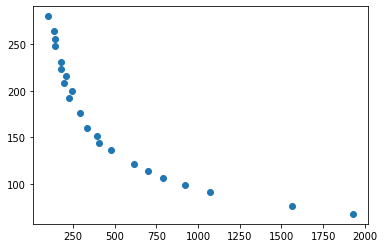

In [15]:
y = np.array([68,76,91,99,106,114,121,137,144,152,160,176,192,200,208,216,223,231,248,256,264,280]) # distance,
x = np.array([get_area(str(i)+'.jpg', 'train_images') for i in y]) # area
plt.scatter(x,y)
plt.show()

Here, the x-axis is the area and the y-axis is the distance We can clearly see that there's a quadratic relation between distance and the area. It seems like the greater the distance, the smaller the range is. 

Now what we want to do is fit a linear regression line to it and estimate the distance in testset.

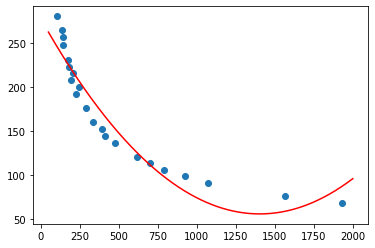

In [16]:
n = len(x)
array_with_ones = np.ones((n,1))
x = np.reshape(x,(n,1))
x_square = x**2

X = np.hstack((array_with_ones, x, x_square))
Y = y

XT = np.transpose(X)
XTX = np.dot(XT,X)
XTX_inv = np.linalg.inv(XTX)
XTY = np.dot(XT,Y)

theta = np.dot(XTX_inv,XTY)
x_1 = np.arange(50., 2000, 1)
y_1 = theta[0] + x_1*theta[1] + theta[2]*x_1**2
plt.scatter(x,y)
plt.plot(x_1,y_1,c='r')
plt.show()

Now with this relation we can estimate the distance in test set.

### For example: 4.jpg

In [17]:
area = get_area('4.jpg', 'test_images')
distance =  theta[0] + area*theta[1] + theta[2]*area**2
print('area is:' + str(area))
print('distance is: ' + str(distance))

area is:1316.0
distance is: 57.031429891091676


## Conclusion

We can see with a gaussian mixture model we can successfully cluster colors. This algrithm is really strong however it also has some limitations. For example one of the limitations is that it is really sensitive to color. The object must have distinctively different color from the backgroud color. Also my test result shows that, if the image is really blurry, this alghrithm failes to capture it's true area because only the part in the middle is captured and the boundary is blury so it is not included in the area. This will cause our algrithm fail to capture the object even though it is in the image. This is what happend to test image 2. Even I could capture the orange ball in test image 3, I falsely identified it's distance because only the center part of the ball is captured so the algrithm will think that the ball is small so it is far away from the camera.

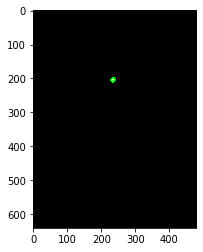

In [34]:
img = cv.imread('test_images/8.jpg')
img_shape = np.shape(img[:,:,0])
b, g, r = cv.split(img)
b = b.flatten()
g = g.flatten()
r = r.flatten()
X = np.transpose(np.vstack((r,g,b)))
    
cut_off = 10e-7
pdf = [0]*len(X)
for j in range(k):
    pdf += multivariate_normal(mu[j],sig[j]).pdf(X)

for i in range(len(X)):
    if pdf[i] < cut_off:
        X[i] = np.array([0,0,0])
    else:
        X[i] = np.array([255,255,255])
            
r = X[:,0]
r = np.reshape(r,img_shape)

g = X[:,1]
g = np.reshape(g,img_shape)

b = X[:,2]
b = np.reshape(b,img_shape)
    
i = cv.merge((b,r,g))
kernel = np.ones((5,5),np.uint8)
i = cv.morphologyEx(i, cv.MORPH_OPEN, kernel)
i = cv.morphologyEx(i, cv.MORPH_CLOSE, kernel)



imgray = cv.cvtColor(i, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
cnt_img = cv.drawContours(i, contours, -1, (0,255,0), 3)

(x,y),radius = cv.minEnclosingCircle(cnt)
center = (int(x),int(y))
radius = int(radius)
circle_img = cv.circle(i,center,radius,(0,255,0),2)
cv.imwrite('8_242.98.jpg',circle_img)
plt.imshow(circle_img)
    
area = cv.contourArea(contours[0])